In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
# Choose data
df = pd.read_parquet("data/2013.parquet")

# Data Types

In [4]:
df.dtypes

title             object
type              object
citations         object
published_date    object
updated_date      object
abstract          object
text              object
url               object
dtype: object

Will convert these to be more specific in handling of each feature below.

# Null Values

In [5]:
df = df.replace("", None)
na = df.isna()
round(na.mean(), 2)

title             0.00
type              0.83
citations         1.00
published_date    0.00
updated_date      0.00
abstract          0.10
text              0.02
url               0.00
dtype: float64

# Duplicates

We only care about knowing of duplicates in the text we will be using to train our model, so we need only check the column `text`.

In [6]:
def find_duplicates(df: pd.DataFrame, feature: str) -> pd.DataFrame:
    assert feature in df.columns, f"{feature} is not a feature in DataFrame."
    duplicate_values = df[df[feature].duplicated() & df[feature].notna() & (df[feature] != "")][feature]
    duplicates = df[df[feature].isin(duplicate_values)].sort_values(feature)
    return duplicates

In [9]:
find_duplicates(df, "text")

,title,type,citations,published_date,updated_date,abstract,text,url
id,,,,,,,,
25215586,Education and Social Work handbook,unknown,None,2006-01-01T00:00:00,2022-02-24T00:24:29,2006 handbook for the faculty of Education and...,The University of Sydney \nFaculty of Educatio...,https://core.ac.uk/download/41230036.pdf
24072203,Education and Social Work handbook,unknown,None,2006-01-01T00:00:00,2022-02-24T14:57:04,2006 handbook for the faculty of Education and...,The University of Sydney \nFaculty of Educatio...,https://core.ac.uk/download/41230036.pdf


If multiples works have the same `text`, we will take keep only the copy that was updated most recently.

In [10]:
df = df.sort_values("updated_date")
df = df.drop_duplicates("text", keep="last")

##### TODO: soften the above so that it finds approximate and not just exact matches

# Features

In [11]:
def plot_feature(feature):
    value_counts = df[feature].value_counts(dropna=False)
    value, count = ["na" if not v else v for v in value_counts.index], value_counts.values
    plt.bar(value, count)
    plt.xlabel(f"{feature}")
    plt.ylabel("count")
    plt.title(f"{feature} data")

## Type

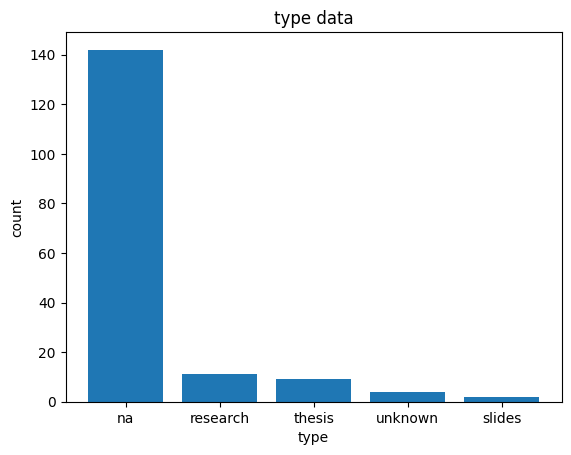

In [12]:
plot_feature("type")

What works are of "unknown" type?

In [13]:
df[df.type == "unknown"]

,title,type,citations,published_date,updated_date,abstract,text,url
id,,,,,,,,
24072203,Education and Social Work handbook,unknown,None,2006-01-01T00:00:00,2022-02-24T14:57:04,2006 handbook for the faculty of Education and...,The University of Sydney \nFaculty of Educatio...,https://core.ac.uk/download/41230036.pdf
5147122,Development Of Identification Technique By FTI...,unknown,None,2007-02-01T00:00:00,2022-02-28T00:02:47,Analisis kualitatif dan kuantitatif terhadap h...,DEVELOPMENT OF IDENTIFICATION \nTECHNIQUE BY F...,https://core.ac.uk/download/11932472.pdf
369057,Amino acid transporters & amino acid metabolis...,unknown,None,2007-01-01T00:00:00,2022-03-16T11:27:20,The development of new drugs against Human Afr...,Amino Acid Transporters & Amino Acid Metabolis...,https://core.ac.uk/download/370935.pdf
134766682,Science handbook,unknown,None,2006-01-01T00:00:00,2022-12-13T03:23:44,2006 handbook for the faculty of Scienc,The University of Sydney Faculty of Science Ha...,https://core.ac.uk/download/41230055.pdf


## Citations

Citations seem to be mostly or all `None`, making it a useless feature.

In [14]:
np.all(df.citations.isna())

True

## Dates

Convert to datetime format.

In [15]:
df["published_date"] = pd.to_datetime(df.published_date)
df["updated_date"] = pd.to_datetime(df.updated_date)

Distribution of dates.

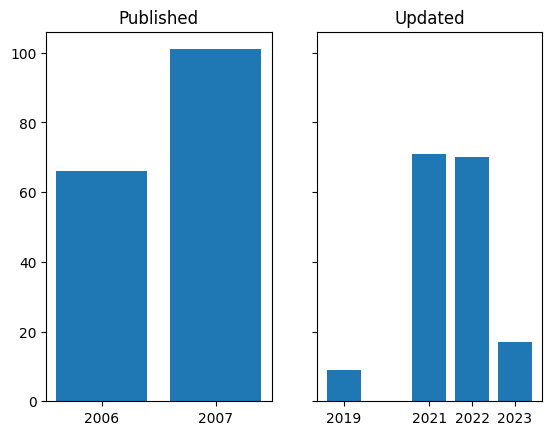

In [35]:
works_published_per_year = df.groupby(df.published_date.dt.year)["text"].count()
works_updated_per_year = df.groupby(df.updated_date.dt.year)["text"].count()
works_per_year = [works_published_per_year, works_updated_per_year]
titles = ["Published", "Updated"]

fig, axs = plt.subplots(1, len(works_per_year), sharey=True)
for i in range(len(works_per_year)):
    data = works_per_year[i]
    year, count = data.index, data.values
    axs[i].bar(year, count)
    axs[i].set_title(titles[i])
    axs[i].set_xticks(year)

## Text

Drop works without text.

In [6]:
df.text.isna().sum()

18

In [55]:
df = df.dropna(subset="text")

Distribution of length.

In [58]:
word_counts = df.text.map(lambda x: len(x.split()))

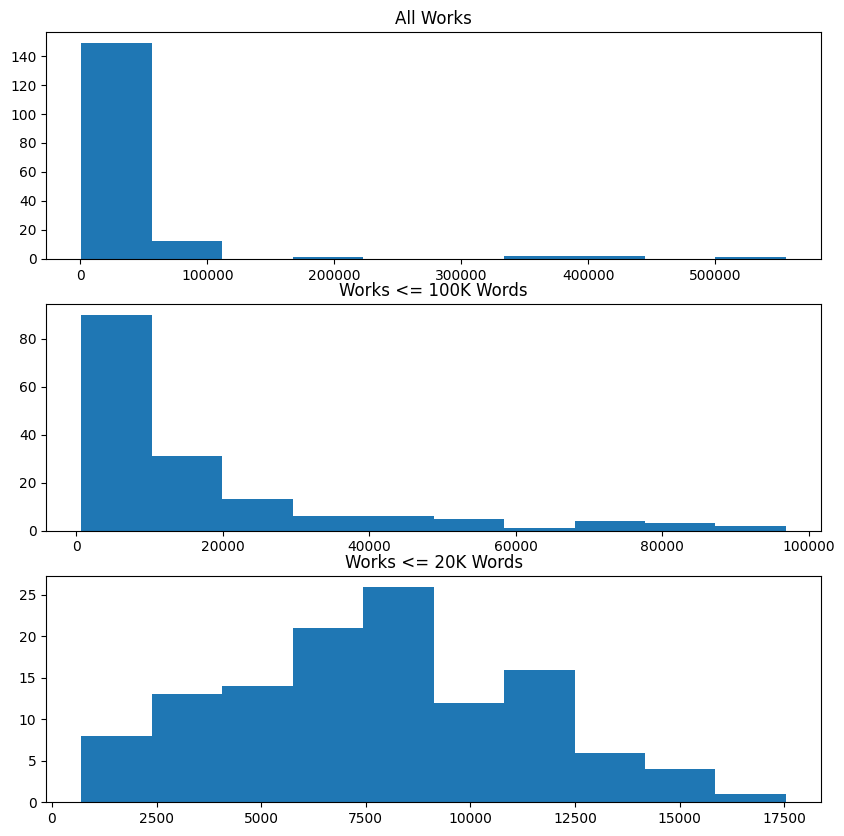

In [71]:
all_works = word_counts
medium_works = word_counts[word_counts <= 100000]
short_works = word_counts[word_counts <= 20000]
data = [all_works, medium_works, short_works]
titles = ["All Works", "Works <= 100K Words", "Works <= 20K Words"]

fig, axs = plt.subplots(len(data), 1, figsize=(10, 10))
for i in range(len(data)):
    axs[i].hist(data[i])
    axs[i].set_title(titles[i])

Mentions of "metabolomics".

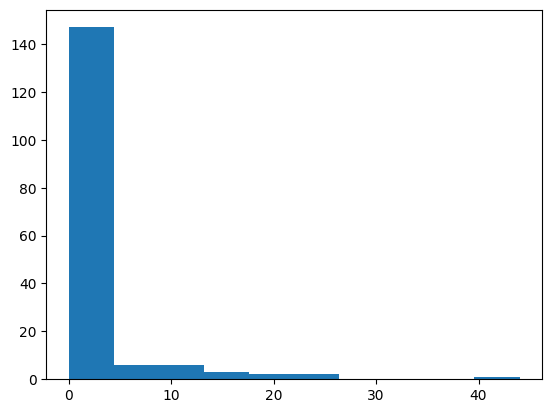

In [76]:
occurrences = df.text.map(lambda x: x.count("metabolomics"))
plt.hist(occurrences)
plt.xlabel("Count of 'metabolomics'")
plt.ylabel("Number of Works")